### Overfitting
we'll explore how to identify overfitting and what you can do to avoid it.<br>

1. <b>import data</b>
2. <b>Bias And Variance</b>
3. <b>Multivariate Models </b>
4. <b> Cross Validation </b>
5. <b>Conclusion</b>

In [1]:
import json
import matplotlib
import pandas as pd
import numpy as np
import warnings
from IPython.core.pylabtools import figsize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import KFold
from matplotlib import pyplot as plt

warnings.simplefilter('ignore')
root = r"/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/styles/bmh_matplotlibrc.json"
s = json.load(open(root))
matplotlib.rcParams.update(s)
% matplotlib inline

In [2]:
# import the data
headers =["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year",
          "origin", "car name"]

_root = '/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML/data/auto.csv'
cars = pd.read_table(_root, delim_whitespace = True, names = headers)
filtered_cars = cars[cars['horsepower'] != '?']
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')
filtered_cars.tail()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,ford ranger
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,chevy s-10


### Bias And Variance
At the heart of understanding overfitting is understanding $bias$ and $variance$. <b>Bias</b> and <b>variance</b> make up the 2 observable sources of error in a model that we can indirectly control.<br><br>
<b>Bias</b> describes error that results in bad assumptions about the learning algorithm. For example, assuming that only one feature, like a car's weight, relates to a car's fuel efficiency will lead you to fit a simple, univariate regression model that will result in high bias. The error rate will be high since a car's fuel efficiency is affected by many other factors besides just its weight.<br><br>
<b>Variance</b> describes error that occurs because of the variability of a model's predicted values. If we were given a dataset with 1000 features on each car and used every single feature to train an incredibly complicated multivariate regression model, we will have low bias but <i>high variance</i>.<br><br>
In an ideal world, we want low bias and low variance but in reality, there's always a <i>tradeoff</i>.

### Bias-Variance Tradeoff

We've discussed before how overfitting generally happens when a model performs well on a training set but doesn't generalize well to new data. A key nuance here is that you should think of overfitting as a relative term. Between any 2 models, one will overfit more than the other one.<br><br>
Understanding [the bias variance tradeoff](https://en.wikipedia.org/wiki/Bias–variance_tradeoff) is critical to understanding overfitting. Every process has some amount of inherent noise that's unobservable.

Overfit models tend to capture the noise as well as the signal in a dataset.

Scott Fortman Roe's blog post on the bias-variance tradeoff has a [wonderful image](http://scott.fortmann-roe.com/docs/BiasVariance.html) that describes this tradeoff:<br><br>
<a href="http://imgur.com/EzkvjzV"><img src="http://i.imgur.com/EzkvjzV.png" , width = 500 /></a>
We can approximate the bias of a model by training a few different models from the same class (linear regression in this case) using different features on the same dataset and calculating their error scores. For regression, we can use mean absolute error, mean squared error, or R-squared.

We can calculate the variance of the predicted values for each model we train and we'll observe an increase in variance as we build more complex, multivariate models.

While an extremely simple, univariate linear regression model will $underfit$, an extremely complicated, multivariate linear regression model will $overfit$. 

Depending on the problem you're working on, there's a happy middle ground that will help you construct reliable and useful predictive models.

Let's first create a function <i>train_and_test</i>, that we can use for training the model and computing the bias and variance values and use it to train some simple, univariate models.

In [3]:
def train_and_test(col_name):
    """
    Convenience function:
        Run simple linear regression, compute and return the variance and error
    """
    features = filtered_cars[col_name]
    target = filtered_cars["mpg"]
    lr = LinearRegression()
    lr.fit(features, target)
    predictions = lr.predict(features)
    
    mse = mean_squared_error(target, predictions)
    var = np.var(predictions)
    return mse, var
 
# train the model using only cylinders
cyl_mse, cyl_var = train_and_test(["cylinders"])

# train the model using only the weight
weight_mse, weight_var = train_and_test(["weight"])

### Multivariate models
Now that we have a function for training a regression model and calculating the mean squared error and variance, let's use it to train and understand more complex models

In [4]:
one_mse, one_var = train_and_test(["cylinders"])
two_mse, two_var = train_and_test(["cylinders", "displacement"])
three_mse, three_var = train_and_test(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_test(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration",
                                       "model year", "origin"])

### Cross Validation
The multivariate regression models we trained got progressively better at reducing the amount of error.

<b>A good way to detect if the model is overfitting is to compare the $in-sample-error$ and the $out-of-sample-error$, or the training error with the test error</b>.

So far, we calculated the in sample error by testing the model over the same data it was trained on.

To calculate the out-of-sample error, we need to test the data on a test set of data. We unfortunately don't have a separate test dataset and we'll instead use cross validation.

If a model's cross validation error (out-of-sample error) is much higher than the in sample error, then our data science senses should start to tingle. This is the first line of defense against overfitting and is a clear indicator that the trained model doesn't generalize well outside of the training set.

Let's create a new function to handle performing the cross validation and computing the cross validation error.

In [5]:
def train_and_cross_val():
    """
    Convenience function:
        train a linear regression using KFolds cross validation and 
        return the average mse and variance across all the folds
    """
    variance_values = []
    mse_values = []
    
    features = filtered_cars[col_name]
    target = filtered_cars["mpg"]
    
    #initialize the cross validation folds
    kf = KFold(features.shape[0], n_folds = 10, shuffle = True, random_state = 3)
    
    #iterate through over each fold.
    for train_index, test_index in kf:
        X_train, X_test = features.iloc[train_index], features[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        # fit the model and make predictions
        lr = LinearRegression()
        lr.fit(X_train, y_train)
        predictions = lr.predict(X_test)
        
        # calculate the mse and var
        mse = mean_squared_error(y_test, predictions)
        var = np.var(predictions)
        
        variance_values.append(var)
        mse_values.append(mse)
    
    avg_mse = np.mean(variance_values)
    avg_var = np.mean(mse_values)
    
    return avg_mse, avg_var
        

    
    
    

one_mse, one_var = train_and_test(["cylinders"])
two_mse, two_var = train_and_test(["cylinders", "displacement"])
three_mse, three_var = train_and_test(["cylinders", "displacement", "horsepower"])
four_mse, four_var = train_and_test(["cylinders", "displacement", "horsepower", "weight"])
five_mse, five_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration"])
six_mse, six_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration", "model year"])
seven_mse, seven_var = train_and_test(["cylinders", "displacement", "horsepower", "weight", "acceleration",
                                       "model year", "origin"])

### Plotting Cross-Validation Error Vs. Cross-Validation Variance
During cross validation, the more features we added to the model, the lower the mean squared error got. This is a good sign and indicates that the model generalizes well to new data it wasn't trained on. As the mean squared error value went up, however, so did the variance of the predictions. This is to be expected, since the models with lower squared error values had higher model complexity, which tends to be more sensitive to small variations in input values (or high variance).

For each model, let's plot the error and variance to get a better idea of the tradeoff as the number of features increased.

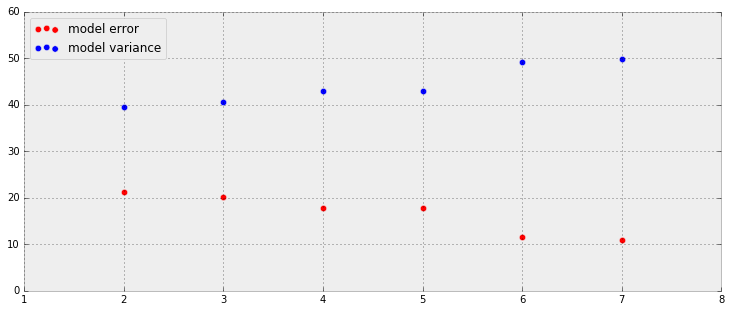

In [6]:
figsize(12.5, 5)
plt.scatter([2, 3, 4, 5, 6, 7], [two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse], c = "r", s=  40, 
           label = 'model error')
plt.scatter([2, 3, 4, 5, 6, 7], [two_var, three_var, four_var, five_var, six_var, seven_var], c = "b", s = 40,
           label = 'model variance')
plt.legend(loc = 'upper left');

### Conclusion
While the higher order multivariate models overfit in relation to the lower order multivariate models, the in-sample error and out-of-sample didn't deviate by much. The best model was around 50% more accurate than the simplest model. On the other hand, the overall variance increased around 25% as we increased the model complexity. This is a really good starting point, but your work is not done! 

The increased variance with the increased model complexity means that your model will have more unpredictable performance on truly new, unseen data.

If you were working on this problem on a data science team, you'd need to confirm the predictive accuracy of the model using completely new, unobserved data (e.g. maybe from cars from later years). Since often you can't wait until a model is deployed in the wild to know how well it works, the exploration we did in this mission helps you approximate a model's real world performance.

In [7]:
from IPython.core.display import HTML


def css_styling():
    styles = open("/Users/Kenneth-Aristide/anaconda3/bin/python_prog/ML_Training/styles/custom.css", "r").read()
    return HTML(styles)
css_styling()